## Project Description 
**Descripcion del proyecto**

Film Junky Union, a modern and innovative community for classic movie enthusiasts, is developing a system to filter and categorize movie reviews. Your task is to train a model that can automatically detect negative reviews. To do so, you will use a dataset of IMDB movie reviews with polarity labels to build a model that classifies reviews as positive or negative. The goal is for the model to achieve an F1 score of at least 0.85.

## Inicialization

In [27]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

sns.set_theme()  # Aplica los estilos de Seaborn sin necesidad de plt.style.use()

#plt.style.use('seaborn')

In [29]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Load data

In [30]:
df_reviews = pd.read_csv('dataset/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [31]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [32]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### Data Description
`tconst (object)`:
A unique identifier for each title, often a code used in databases like IMDb.

`title_type (object):`
The type of content, such as "movie", "series", "documentary", etc.

`primary_title (object):`
The main title of the work, typically the most recognized name.

`original_title (object):`
The original title of the work, possibly in the original language.

`start_year (int64):`
The year the title was first broadcast or premiered.

`end_year (object):`
The year the title ended, applicable to series or multi-season content. It may be empty or contain values like "NULL" if not applicable.

`runtime_minutes (object):`
The duration of the title in minutes. May include non-numeric values, such as "NULL", if not specified.

`is_adult (int64):`
Indicates whether the content is for adults (0 = no, 1 = yes).

`genres (object):`
Genres associated with the title, separated by commas (e.g., "Drama, Comedy").

`average_rating (float64):`
The average user rating of the title, on a floating-point scale.

`votes (Int64):`
The number of votes received by the title. May contain null values.

`review (object):`
Text comments or reviews associated with the title.

`rating (int64):`
The score or rating assigned to the title.

`sp (object):`
The sentiment of the review ('pos' = positive, 'neg' = negative).

`pos (int64):`
The target value, with '0' for negative reviews and '1' for positive reviews.

`ds_part (object):`
Indicates the subset of the dataset (e.g., whether it belongs to the training or test set).

`idx (int64):`
A unique index to identify each row within the dataset.



**Objective**: The goal is to classify the reviews as positive or negative, regardless of the genre, year, or title of the movie. Therefore, data processing will primarily focus on the review, pos, and ds_part columns.

We identified only two records with missing values. Considering their proportion in the dataset, the simplest approach will be to remove them.

In [33]:
df_reviews.dropna(inplace=True)

In [34]:
review_cols = ['review', 'pos', 'ds_part'] 
df_reviews[df_reviews.duplicated(subset='review')][review_cols]

,review,pos,ds_part
1370,I have seen this film at least 100 times and I...,1,test
1630,THE JIST: See something else. This film was hi...,1,train
1983,This movie is very scary with scenes where the...,0,test
2132,I saw this in the summer of 1990. I'm still an...,0,train
2236,This is an Emperor's New Clothes situation. So...,0,test
...,...,...,...
46064,"During a Kurt Weill celebration in Brooklyn, W...",1,train
47052,Everyone knows about this ''Zero Day'' event. ...,1,train
47194,German filmmaker Ulli Lommel has managed a tas...,0,train
47290,Nickelodeon has gone down the toilet. They hav...,0,test


To avoid overfitting, duplicate reviews will be removed.

In [35]:
df_reviews.drop_duplicates(subset='review', inplace=True)

### EDA

Now, let's examine the number of films and reviews over the years.

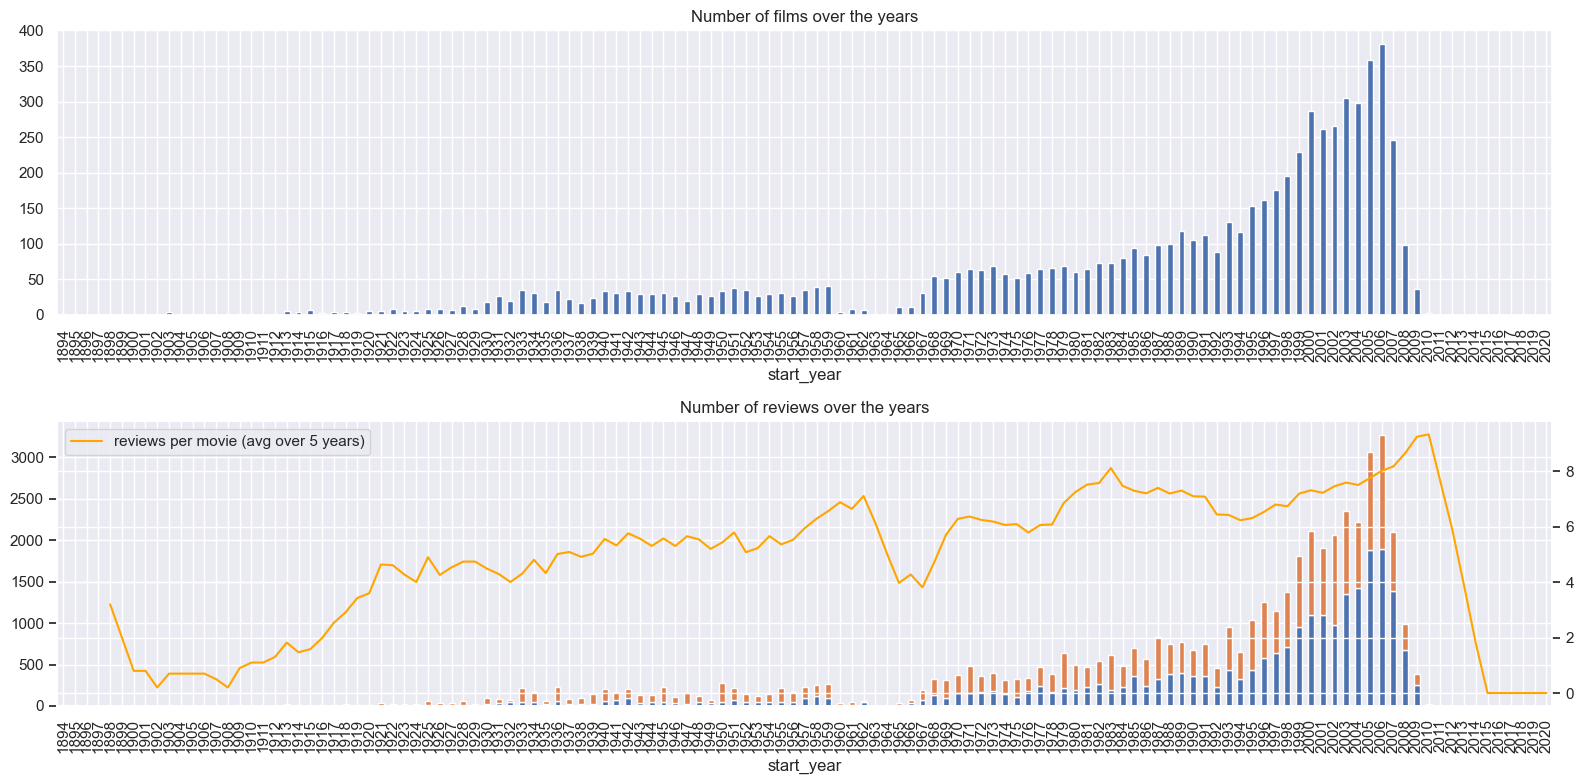

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of films over the years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of reviews over the years')

fig.tight_layout()

Let's examine the distribution of the number of reviews per movie, using both the exact count and the KDE, to observe any differences between them.

A noticeable difference exists between the exact count of reviews per year and the moving average. In years with fewer reviews, the moving average tends to be significantly higher.

The correlation between the number of movies released per year and the number of reviews is expected more movies naturally lead to more reviews.

c:\Users\Molix.x\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


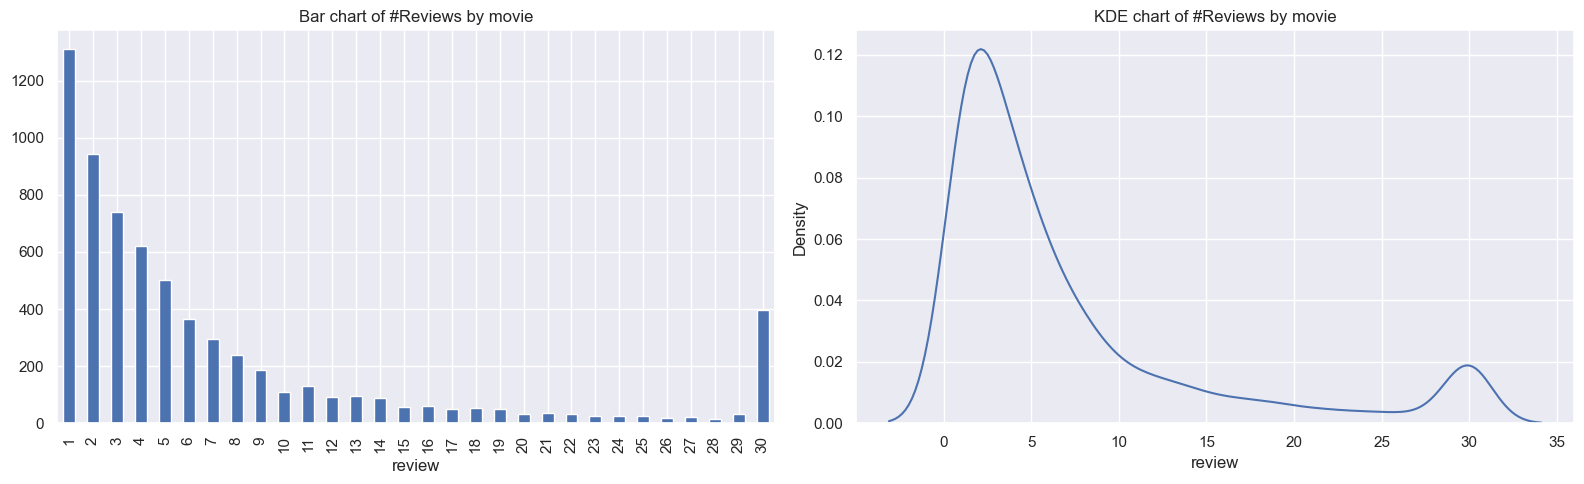

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of #Reviews by movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE chart of #Reviews by movie')

fig.tight_layout()

The distribution of the number of reviews per movie, shown through the bar chart and the KDE chart, is much more similar in this case. This suggests that the spread of reviews across movies is relatively consistent, and the two methods (exact count and KDE) provide a similar view of the data. In contrast, the distribution of the number of movies per year shows a clearer difference between the bar chart and the KDE, indicating that the number of movies released each year may have more variability, with some years having significantly more movies than others.

This comparison highlights that while the number of reviews follows a more stable distribution across movies, the volume of movies released per year fluctuates more, which could explain the differences observed in the yearly data.

In [38]:
df_reviews['pos'].value_counts()

pos
0    23680
1    23558
Name: count, dtype: int64

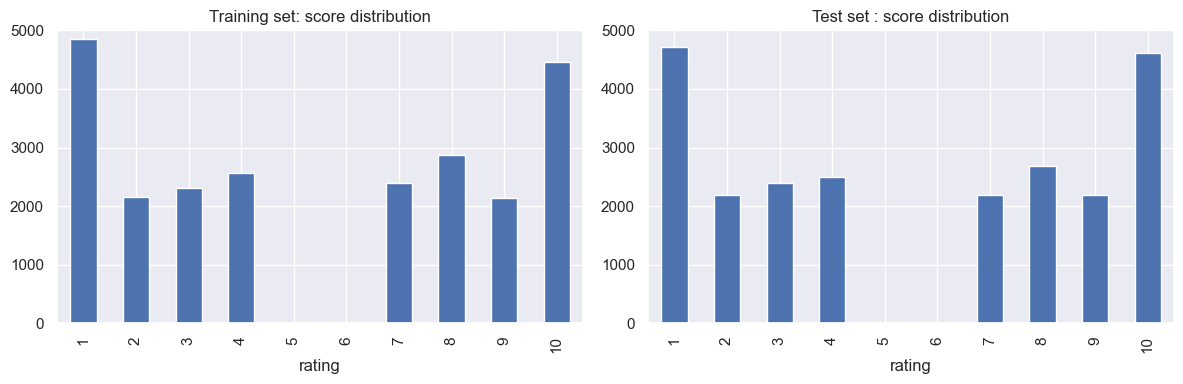

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training set: score distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set : score distribution')

fig.tight_layout()

Despite the fact that the reviews are heavily polarized at the extremes (1 and 10), with no apparent data in the intermediate scores, this is still useful, and no significant class imbalance is observed. On the contrary, the distribution appears to be quite symmetrical in both the training and validation sets.

Distribution of negative and positive reviews over the years for two subsets of the dataset:
The distribution of positive and negative reviews across the years provides insight into how sentiment might have shifted over time. By analyzing this, we can see if there are certain periods where one sentiment dominates or if both remain relatively consistent throughout the years. This distribution analysis helps in understanding the evolution of sentiment and its impact on the overall data set

c:\Users\Molix.x\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Molix.x\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Molix.x\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Molix.x\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

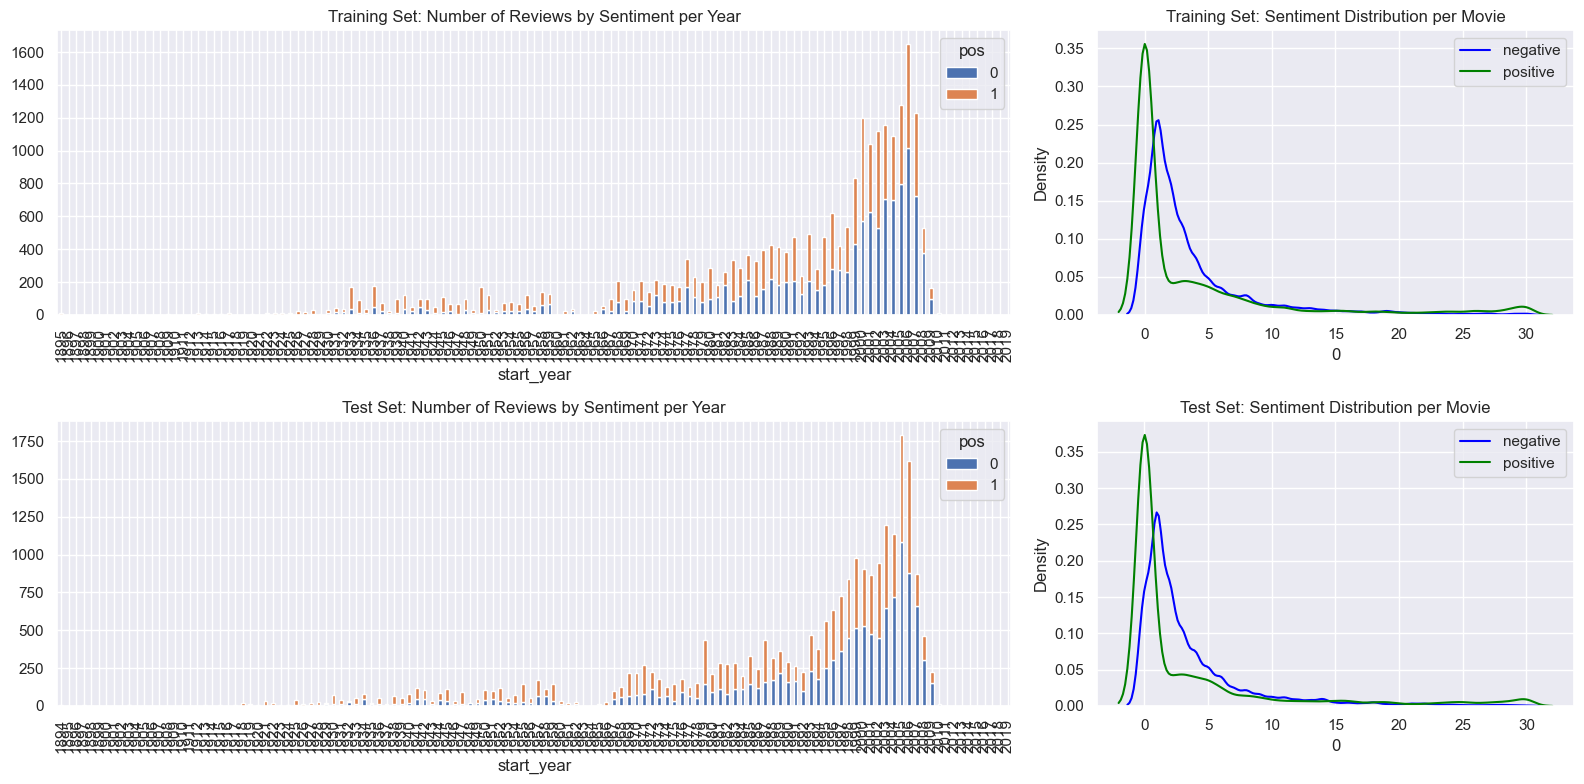

In [40]:
# Create subplots with specific grid ratios
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# ---- Plot 1: Number of reviews per year (Training Set) ----
ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()

# Convert index to integer and fill missing years with zeros
dft.index = dft.index.astype(int)
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020)), fill_value=0)

# Create stacked bar plot
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training Set: Number of Reviews by Sentiment per Year')

# ---- Plot 2: Sentiment distribution per movie (Training Set) ----
ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack().fillna(0)

# Replace infinite values with NaN and drop them
dft.replace([np.inf, -np.inf], np.nan, inplace=True)
dft.dropna(inplace=True)

# KDE Plots (Only if columns exist)
if 0 in dft.columns:
    sns.kdeplot(dft[0], color='blue', label='negative', bw_adjust=0.5, ax=ax)
if 1 in dft.columns:
    sns.kdeplot(dft[1], color='green', label='positive', bw_adjust=0.5, ax=ax)

ax.legend()
ax.set_title('Training Set: Sentiment Distribution per Movie')

# ---- Plot 3: Number of reviews per year (Test Set) ----
ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()

# Convert index to integer and fill missing years with zeros
dft.index = dft.index.astype(int)
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020)), fill_value=0)

# Create stacked bar plot
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test Set: Number of Reviews by Sentiment per Year')

# ---- Plot 4: Sentiment distribution per movie (Test Set) ----
ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack().fillna(0)

# Replace infinite values with NaN and drop them
dft.replace([np.inf, -np.inf], np.nan, inplace=True)
dft.dropna(inplace=True)

# KDE Plots (Only if columns exist)
if 0 in dft.columns:
    sns.kdeplot(dft[0], color='blue', label='negative', bw_adjust=0.5, ax=ax)
if 1 in dft.columns:
    sns.kdeplot(dft[1], color='green', label='positive', bw_adjust=0.5, ax=ax)

ax.legend()
ax.set_title('Test Set: Sentiment Distribution per Movie')

# Adjust layout and show plot
fig.tight_layout()
plt.show()

In the dataset, negative reviews are generally twice as frequent as positive ones, especially in titles with a large number of reviews. On the other hand, titles with a higher proportion of positive reviews tend to have a smaller total number of reviews. This suggests that while negative reviews dominate in more popular titles, those with more positive feedback are often less frequently reviewed, potentially indicating a more niche or selective audience.

### Evaluation Procedure
This section describes the evaluation routine that will be applied to all models in this project.

In [41]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evaluates a classification model using multiple metrics, including F1-score, ROC AUC, 
    and Precision-Recall Curve (PRC). Plots relevant evaluation graphs for both training 
    and test datasets.
    
    Parameters:
        model: Trained model to evaluate.
        train_features: Feature matrix for the training set.
        train_target: Target labels for the training set.
        test_features: Feature matrix for the test set.
        test_target: Target labels for the test set.
    
    Returns:
        None. Prints a summary of evaluation metrics and displays plots.
    """
    
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for dataset_type, features, target in [('train', train_features, train_target), ('test', test_features, test_target)]:
        eval_stats[dataset_type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1-score across different thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]

        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[dataset_type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve (PRC)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[dataset_type]['APS'] = aps
        
        color = 'blue' if dataset_type == 'train' else 'green'

        # F1-score plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{dataset_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Mark key thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score') 

        # ROC Curve plot
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{dataset_type}, ROC AUC={roc_auc:.2f}')
        
        # Mark key thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # Precision-Recall Curve plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{dataset_type}, AP={aps:.2f}')
        
        # Mark key thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')        

        # Store additional evaluation metrics
        eval_stats[dataset_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[dataset_type]['F1'] = metrics.f1_score(target, pred_target)
    
    # Format and print evaluation results
    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=['Accuracy', 'F1', 'APS', 'ROC AUC'])
    
    print(df_eval_stats)
    return


Normalization
We assume that all the models below accept text in lowercase and without digits, punctuation marks, etc.

In [42]:
import re 

# Define a pattern to remove all characters except letters and apostrophes
pattern = r"[^a-zA-Z']"

# Apply normalization to each review
review_norm = []
for review in df_reviews['review']:
    normalized_text = re.sub(pattern, " ", review)  # Replace unwanted characters with spaces
    review_norm.append(normalized_text.lower())  # Convert to lowercase

# Store the cleaned text in a new column
df_reviews['review_norm'] = review_norm


In [43]:
df_reviews[['review','review_norm']].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenti...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...


### Train/Test Split
Fortunately, the entire dataset is already divided into training and test sets. The column 'ds_part' serves as the corresponding indicator.

In [44]:
# Create separate DataFrames for training and test data
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Extract target variables
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Print dataset shapes
print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23757, 18)
(23481, 18)


### Working with Models
#### **Model 0 - Constant (Baseline Model)**

In [45]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

# Initialize a baseline classifier with a uniform strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the model using the training data
dummy_clf.fit(df_reviews_train, train_target)

# Generate predictions on the test set
const_predict = dummy_clf.predict(df_reviews_test)

# Calculate evaluation metrics
accuracy = metrics.accuracy_score(test_target, const_predict)
f1 = metrics.f1_score(test_target, const_predict)
aps = metrics.average_precision_score(test_target, const_predict)
roc_auc = metrics.roc_auc_score(test_target, const_predict)

# Print results
print(f'''Baseline Model (Constant)
Accuracy : {accuracy:.2f}
F1 Score : {f1:.2f}
APS      : {aps:.2f}
ROC AUC  : {roc_auc:.2f}''')

Baseline Model (Constant)
Accuracy : 0.50
F1 Score : 0.50
APS      : 0.50
ROC AUC  : 0.50


Due to the approximately balanced distribution of classes in the dataset, the strategy parameter of DummyClassifier was set to 'uniform'. This configuration generates random predictions with a uniform probability for each class.

The results show an accuracy close to 50%, which is expected since this model is equivalent to selecting labels at random without considering the input data. This confirms that the model has no predictive power and serves only as a baseline for comparison with more advanced models.

#### **Model 1 - NLTK, TF-IDF, and Logistic**

TF-IDF Vectorization

In [46]:
import nltk  
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression  
from nltk.corpus import stopwords as nltk_stopwords  

# Extract training and test corpus  
train_corpus = df_reviews_train['review_norm']  
test_corpus = df_reviews_test['review_norm']  

# Define stopwords and convert to list
stop_words = list(nltk_stopwords.words('english')) 

# Initialize TF-IDF vectorizer  
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)  

# Fit the vectorizer only on the training set  
train_features_1 = tfidf_vectorizer_1.fit_transform(train_corpus)  

# Transform the test set using the trained vocabulary  
test_features_1 = tfidf_vectorizer_1.transform(test_corpus)  

# Initialize and train the logistic regression model  
model_1 = LogisticRegression()  
model_1.fit(train_features_1, train_target)  


LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


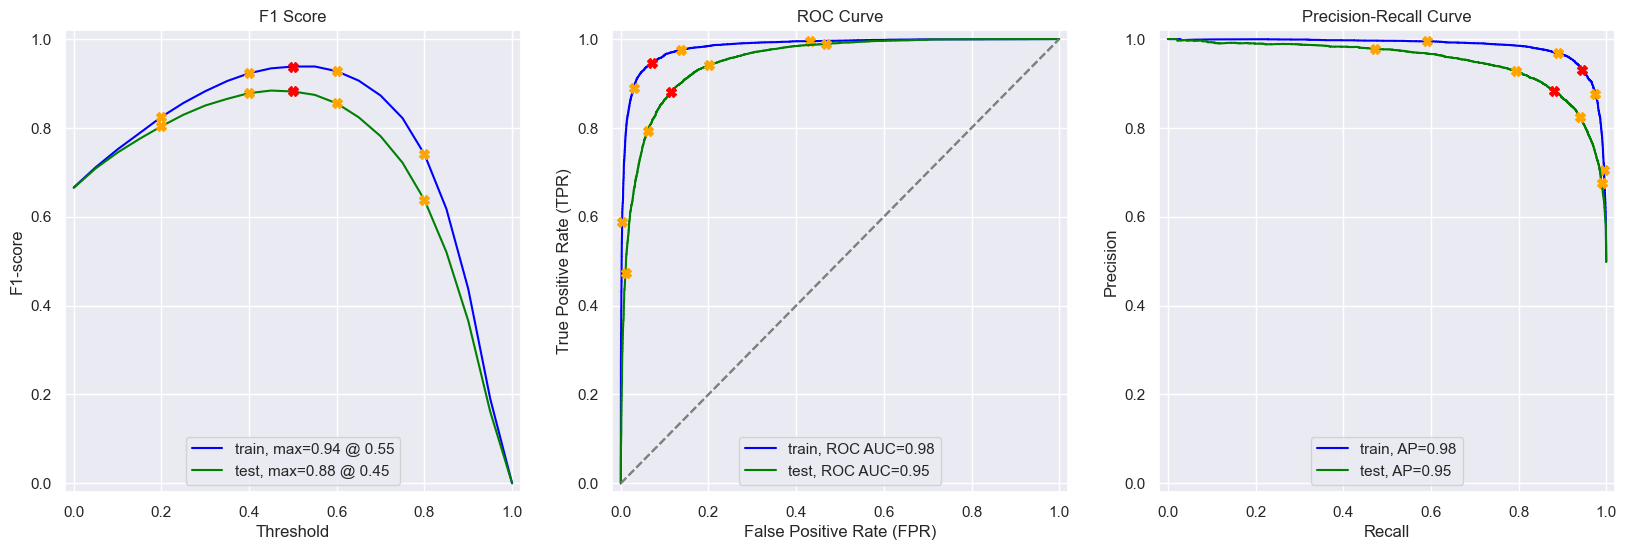

In [47]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The chart shows that the optimal threshold is close to 0.5, with maximum values of 0.55 for the training set and 0.45 for the test set. Both sets achieve Accuracy and F1-Score values higher than the baseline model, with scores of 0.94 and 0.88, respectively, demonstrating the overall strong performance of the model.

The difference in optimal thresholds between the sets can be attributed to the inherent variation in the data, highlighting the sensitivity of these models to changes in input data. This underscores the importance of class balance, as evidenced by the balanced distribution (23,680 positive and 23,558 negative samples), to ensure consistent results and minimize potential biases.

The ROC-AUC curve confirms the model's strong performance, with areas under the curve of 0.98 for the training set and 0.95 for the test set. These values indicate that the model correctly classifies most observations, both positive and negative.
The slight decrease in test set performance could suggest minor overfitting to the training set. However, the difference is not significant, and the test set results remain solid and acceptable.

The chart also shows the relationship between precision and recall. The model maintains high precision even as recall increases, demonstrating its ability to consistently predict positive examples. This behavior is further supported by the balanced distribution of positive and negative classes in the dataset.
The stability of the curve suggests that the model is not only robust in terms of prediction but also efficient at handling balanced data, maximizing the trade-off between precision and recall across different thresholds.

### Modelo 2 - spaCy, TF-IDF y LR

In [ ]:
import spacy

# Load the English spaCy model with disabled components for efficiency
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to tokenize and lemmatize text
def text_preprocessing_2(text):
    """
    Tokenizes and lemmatizes the input text using spaCy.
    
    Args:
        text (str): The input text to process.
    
    Returns:
        str: A string containing the lemmatized words.
    """
    doc = nlp(text)
    # Extract lemmas from tokens (without removing stop words)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)


In [65]:
import gc
gc.collect()

177

In [ ]:
# Apply the text_preprocessing_2 function to each review in the 'review_norm' column
df_reviews_train['review_lemmas'] = df_reviews_train['review_norm'].apply(text_preprocessing_2)
df_reviews_test['review_lemmas'] = df_reviews_test['review_norm'].apply(text_preprocessing_2)

The lemmatization of reviews using the text_preprocessing_3 function takes significantly longer compared to using stop_words. Execution time is a crucial factor when comparing and evaluating models, especially when their accuracy and performance metrics are similar. In such cases, the model with a shorter execution time may be preferable, as it provides a more efficient solution without compromising quality. Therefore, it is essential to analyze the balance between processing time and improvements in metrics to determine the best approach based on the specific use case.

In [ ]:
# Extract the preprocessed reviews (lemmatized text) for training and testing
train_corpus_2 = df_reviews_train['review_lemmas']
test_corpus_2 = df_reviews_test['review_lemmas']


In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer_2 = TfidfVectorizer()

# Fit the vectorizer only on the training dataset and transform it into feature vectors
train_features_2 = tfidf_vectorizer_2.fit_transform(train_corpus_2)

# Transform the test dataset using the vocabulary learned from the training data
test_features_2 = tfidf_vectorizer_2.transform(test_corpus_2)

In [ ]:
# Initialize and train a Logistic Regression model
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


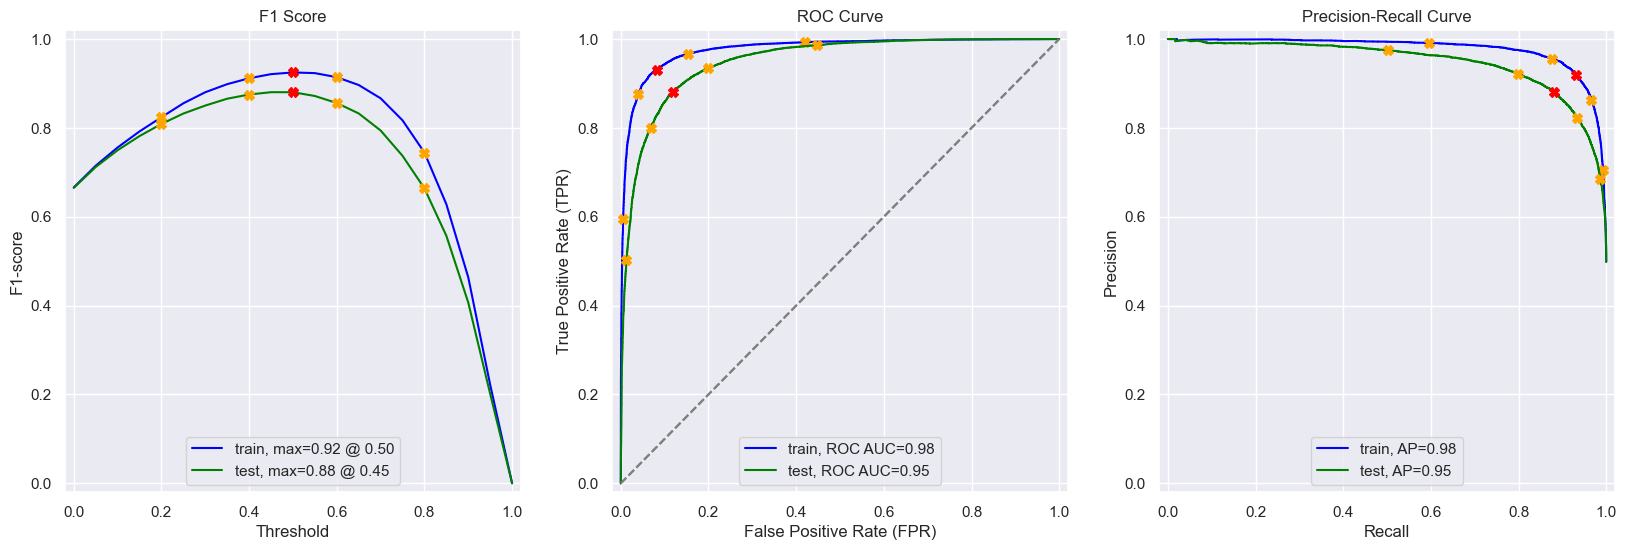

In [ ]:
# Evaluate the model on both training and test datasets
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

The graphs show a performance similar to that of Model 1, with a difference of -0.01 in Accuracy and F1-Score, while the other metrics remain the same. This indicates that Model 2 is almost as precise and consistent as Model 1, while also demonstrating a strong relationship between precision and recall.

However, when evaluating model performance, it is also important to consider execution time. Tokenizing and lemmatizing text using spaCy with the text_preprocessing_2 function requires a significant amount of time, which could be a drawback for training these models. Therefore, although Model 2’s results are satisfactory, its longer processing time could limit its feasibility in applications where efficiency is a priority.

The main difference between Models 1 and 2 is that the first model uses stop_words to remove stopwords, whereas in Model 2, words are tokenized and lemmatized without eliminating terms that may lack meaning or relevance for the analysis. This approach seems to slightly reduce the quality of Model 2.

#### **Model 3 - spaCy, TF-IDF, and LGBMClassifier**
This model will use the tokenized and lemmatized features from the previous model, 
as they have the same characteristics and considering the execution time required for processing.

In [ ]:
import lightgbm as lgb

model_3 = lgb.LGBMClassifier(
    boosting_type='gbdt',       # Boosting type (default: gbdt)
    n_estimators=100,           # Number of trees
    learning_rate=0.1,          # Learning rate
    max_depth=-1,               # Maximum tree depth (-1 = no limit)
    num_leaves=35,              # Number of leaves per tree
    objective='binary',         # Task: binary classification
    random_state=42             # Ensures reproducibility
)

In [ ]:
# Convert feature matrices to float32 to optimize memory usage
train_features_3 = train_features_2.astype('float32')
test_features_3 = test_features_2.astype('float32')

# Train the model
model_3.fit(train_features_2, train_target)

C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11862, number of negative: 11895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.364996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480694
[LightGBM] [Info] Number of data points in the train set: 23757, number of used features: 9447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499305 -> initscore=-0.002778
[LightGBM] [Info] Start training from score -0.002778


LGBMClassifier(num_leaves=35, objective='binary', random_state=42)

C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


          train  test
Accuracy   0.93  0.86
F1         0.93  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


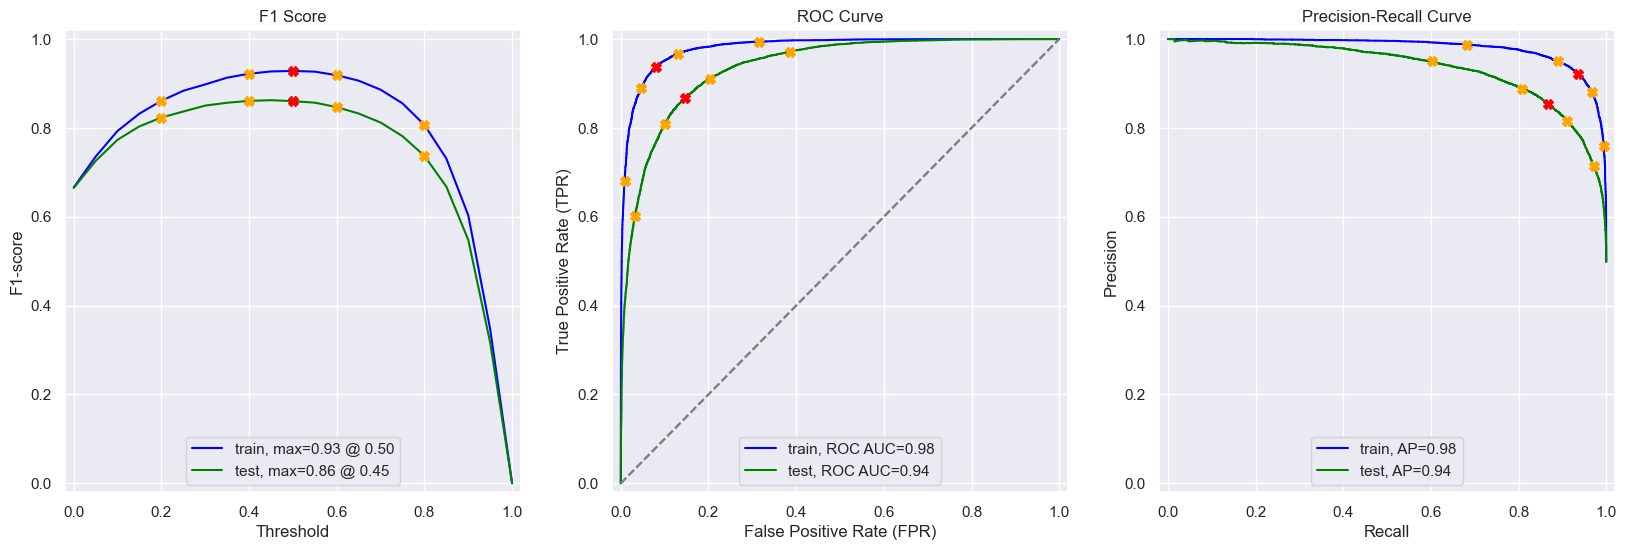

In [ ]:
# Evaluate the model on both training and test sets
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Model 3 requires more resources and execution time compared to the previous models, making it less efficient for this case. Additionally, it shows lower predictive performance, achieving an Accuracy and F1-Score of 0.93 on the training set and 0.86 on the test set.

Although the ROC-AUC and APS values in the training set (0.98) are consistent with the other models, these metrics slightly decreased in the test set (0.94), indicating a slight loss in predictive quality.

However, Model 3 stands out in the first graph (F1 Score) for its greater robustness to threshold variations, which could be an advantage in scenarios where F1 stability is important.

Overall, when considering execution time, predictive quality, and resource requirements, this model would not be the most recommendable option compared to Models 1 and 2.

In [75]:
gc.collect()

11986

### My reviews

In [ ]:
# Create a DataFrame with example reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and fell asleep in the middle of the movie.',
    'I really liked the movie, it was a great musical, and most of the songs were very catchy.',
    'I was really fascinated with the movie.',    
    'The last season completely ruined the whole series and the character development that had been achieved so far.',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! The writers really cared about the source material.',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge episode after episode of this exciting, intelligent new drama.'
], columns=['review'])

# Remove the example reviews and test the models with your own reviews.
# You can uncomment the following section and add your own reviews.

"""
my_reviews = pd.DataFrame([
    'I just didn\'t like it, not my kind of movie.',
    'Well, I was bored and fell asleep halfway through the movie.',
    'I was really fascinated by the movie.',    
    'Even the actors looked really old and uninterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! The writers really cared about the source material.',
    'The movie had its ups and downs, but I feel like overall, it\'s a decent film. I would watch it again.',
    'What a terrible attempt at a comedy. Not a single joke makes sense, everyone acts irritating and loud, even kids won\'t like this!',
    'Releasing on Netflix was a bold move, and I really appreciate being able to binge episode after episode of this exciting, intelligent new drama.'
], columns=['review'])
"""

# Text normalization: remove special characters and convert to lowercase
review_norm = []
for review in my_reviews['review']:
    normal = re.sub(pattern, " ", review)  # Replace special characters with spaces
    review_norm.append(normal.lower())  # Convert text to lowercase

# Add the normalized column to the DataFrame
my_reviews['review_norm'] = review_norm

# Display the DataFrame with normalized reviews
my_reviews


,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I really liked the movie it was a great musica...,i really liked the movie it was a great musica...
3,I was really fascinated with the movie,i was really fascinated with the movie
4,The last season completely ruined the whole se...,the last season completely ruined the whole se...
5,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
6,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good writ...
7,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
8,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
9,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


#### Model 1

In [78]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.90:  i really liked the movie it was a great musical  and most of the songs were very catchy 
0.54:  i was really fascinated with the movie
0.28:  the last season completely ruined the whole series and the character development that had been achie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.30:  i didn't expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


#### Model 2

In [79]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it  not my kind of movie 
0.24:  well  i was bored and felt asleep in the middle of the movie 
0.95:  i really liked the movie it was a great musical  and most of the songs were very catchy 
0.59:  i was really fascinated with the movie
0.35:  the last season completely ruined the whole series and the character development that had been achie
0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn't expect the reboot to be so good  writers really cared about the source material
0.67:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.87:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


#### Model 3

In [80]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it  not my kind of movie 
0.58:  well  i was bored and felt asleep in the middle of the movie 
0.95:  i really liked the movie it was a great musical  and most of the songs were very catchy 
0.63:  i was really fascinated with the movie
0.59:  the last season completely ruined the whole series and the character development that had been achie
0.56:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.42:  i didn't expect the reboot to be so good  writers really cared about the source material
0.78:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.16:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.76:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


C:\Users\Molix.x\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Conclusions
#### **Model 1**
Model 1 performs very well on this set of new reviews, assigning probabilities that reasonably match the tone of the texts. This demonstrates its ability to capture nuances and gradients in opinions, evaluating them on a scale from 0.0 to 1.0. This approach not only allows for classifying reviews as positive or negative but could also be used to generate more detailed scores, such as a star-rating system.

If we define positive reviews as those with a score equal to or greater than 0.5 and negative reviews as those below that threshold, we can conclude that the model correctly classified most of the reviews. This indicates that the model performs well overall, although additional testing with larger and more balanced datasets would be important to assess its robustness more comprehensively.

It is worth noting that one review was misclassified, which could be related to the presence of the word "didn't." Given its negative connotation, it is possible that the model was influenced by this word when calculating the probability, without fully considering the context. Analyzing how specific words affect the model’s predictions on a larger dataset could help identify and mitigate biases in its classifications.

#### **Model 2**
Model 2 shows reasonable performance but is less sensitive to nuances between positive and negative reviews compared to Model 1. Although it classifies many reviews correctly within a binary scheme (positive or negative), its accuracy is lower than that of the previous model.

This behavior highlights the importance of text preprocessing before training the model. Although both models use Linear Regression, differences in text preparation techniques, such as tokenization and vector representation, have a significant impact on the quality of predictions.

While Model 2 could be useful for general classification tasks, it would be important to explore additional preprocessing adjustments or test other configurations to improve its ability to capture the subtleties present in the reviews.

#### **Model 3**
Despite showing optimal results in evaluation metrics for the training and test sets, Model 3 performs disappointingly with the new reviews. According to the classification criterion used (positive if the score is ≥ 0.5 and negative if < 0.5), most reviews were misclassified. Additionally, the model tends to assign high scores even to clearly negative reviews, while some positive reviews received low scores.

The most likely cause is overfitting—the model may have adapted too closely to the training set, learning specific patterns that do not generalize well to new data. This would explain the good performance on training and test sets but poor results with unseen data.

The Accuracy and F1 Score metrics were identical across all three models. This can be explained by the balance in the datasets and the high precision achieved by the models, which significantly reduces the margin of error and, consequently, the differences between these metrics.